This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

# Analysis for PBMC1 sm2

In [53]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib.pyplot import rc_context

import os
import collections

res_name = "pbmc_rep2_sm2"
exp_str = "pbmc2"
method_str = "Smart-seq2"

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# we are working with PBMCs so lets store some marker genes
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

marker_genes_dict = {
    'CD14 Mono': ['CD14', 'LYZ'],
    'CD16 Mono': ['FCGR3A', 'MS4A7'],
    'Dendritic': ['FCER1A', 'CST3'],
    'NK': ['GNLY', 'NKG7', 'KLRB1'],
    'B Cell': ['CD79A', 'MS4A1'],
    #'Plasma': ['IGJ'],
    'CD4 T': ['IL7R'],
    'CD8 T': ['CD8A', 'CD8B'],
    'Megakaryocytes': ['PPBP']
}

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.5 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


## Open files

In [54]:
data_path = f"{os.getcwd()}/../../data/single_cell_data/GSE132044/sm2_hg19/"

results_file = f"{data_path}/{res_name}.h5ad"

adata = sc.read_10x_mtx(
    data_path,                               # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


... reading from cache file cache/beevol-home-davidson-checkouts-sc_bulk_ood-evaluation_experiments-pbmc-..-..-data-single_cell_data-GSE132044-sm2_hg19-matrix.h5ad


In [55]:
# make cell type specific marker annotation

genes_annot_dict = {
    'CD14': ['CD14 (CD14 Mono)'],
    'LYZ': ['LYZ (CD14 Mono)'],
    'FCGR3A': ['FCGR3A (CD16 Mono)'],
    'MS4A7': ['MS4A7 (CD16 Mono)'],
    'FCER1A': ['FCER1A (Dendritic)'],
    'CST3': ['CST3 (Dendritic)'],
    'GNLY': ['GNLY (NK)'],
    'NKG7': ['NKG7 (NK)'],
    'MS4A1': ['MS4A1 (B)'],
    'IL7R': ['IL7R (CD4T)'],
    'CCR7': ['CCR7 (Naive CD4T)'],
    'S100A4': ['S100A4 (Memory CD4T)'],
    'CD8A': ['CD8A (CD8 T)'],
    'PPBP': ['PPBP (Megak)']
}

# Initialize empty column in cell metadata
adata.var['gene_annot'] = adata.var_names

# Generate new assignments
for i in genes_annot_dict.keys():
    ind = np.where(pd.Series(adata.var_names).isin([i]))[0]
    adata.var['gene_annot'].iloc[ind] = genes_annot_dict[i]
adata.var['gene_annot'].iloc[ind]

PPBP    PPBP (Megak)
Name: gene_annot, dtype: object

In [56]:
# add metadata
meta_cols = ['code', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method']
barcodes = pd.read_csv(f"{data_path}/barcodes.tsv", header=None, names=['code'])
meta_data = pd.read_csv(f"{data_path}/GSE132044_meta.txt", skiprows=2, names=meta_cols, index_col='code', sep="\t")
meta_df = barcodes.join(other=meta_data, on=['code'], how='left', sort=False)

adata.obs['CellType'] = meta_df['CellType'].tolist()
adata.obs['Experiment'] = meta_df['Experiment'].tolist()
adata.obs['Method'] = meta_df['Method'].tolist()
meta_df

,code,nGene,nUMI,percent.mito,Cluster,CellType,Experiment,Method
0,pbmc1_SM2_Cell_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,pbmc1_SM2_Cell_107,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,pbmc1_SM2_Cell_108,2200.0,437125.0,0.029743,0.0,Cytotoxic T cell,pbmc1,Smart-seq2
3,pbmc1_SM2_Cell_115,2438.0,335596.0,0.031152,0.0,Cytotoxic T cell,pbmc1,Smart-seq2
4,pbmc1_SM2_Cell_125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
45012,pbmc2_inDrops_1_TAGTCTCT.GAGCCTTA.ATCCGCTA,453.0,717.0,0.097629,11.0,Plasmacytoid dendritic cell,pbmc2,inDrops
45013,pbmc2_inDrops_1_TCCAGAAG.TTATGCGA.TAAGACGG,592.0,938.0,0.035181,11.0,Plasmacytoid dendritic cell,pbmc2,inDrops
45014,pbmc2_inDrops_1_TGAATCCT.GAGCCTTA.CCCAAGCA,406.0,662.0,0.138973,11.0,Plasmacytoid dendritic cell,pbmc2,inDrops
45015,pbmc2_inDrops_1_TGAATCCT.TTATGCGA.CATCTCCC,1001.0,2066.0,0.055663,11.0,Plasmacytoid dendritic cell,pbmc2,inDrops


## Preprocessing

In [57]:
# lets see whats in adata
adata

AnnData object with n_obs × n_vars = 45017 × 33694
    obs: 'CellType', 'Experiment', 'Method'
    var: 'gene_ids', 'gene_annot'

In [58]:
# filter it for only our method and experiment
adata = adata[adata.obs["Experiment"] == exp_str, :]
adata = adata[adata.obs["Method"] == method_str, :]

adata

View of AnnData object with n_obs × n_vars = 273 × 33694
    obs: 'CellType', 'Experiment', 'Method'
    var: 'gene_ids', 'gene_annot'

normalizing counts per cell
    finished (0:00:00)


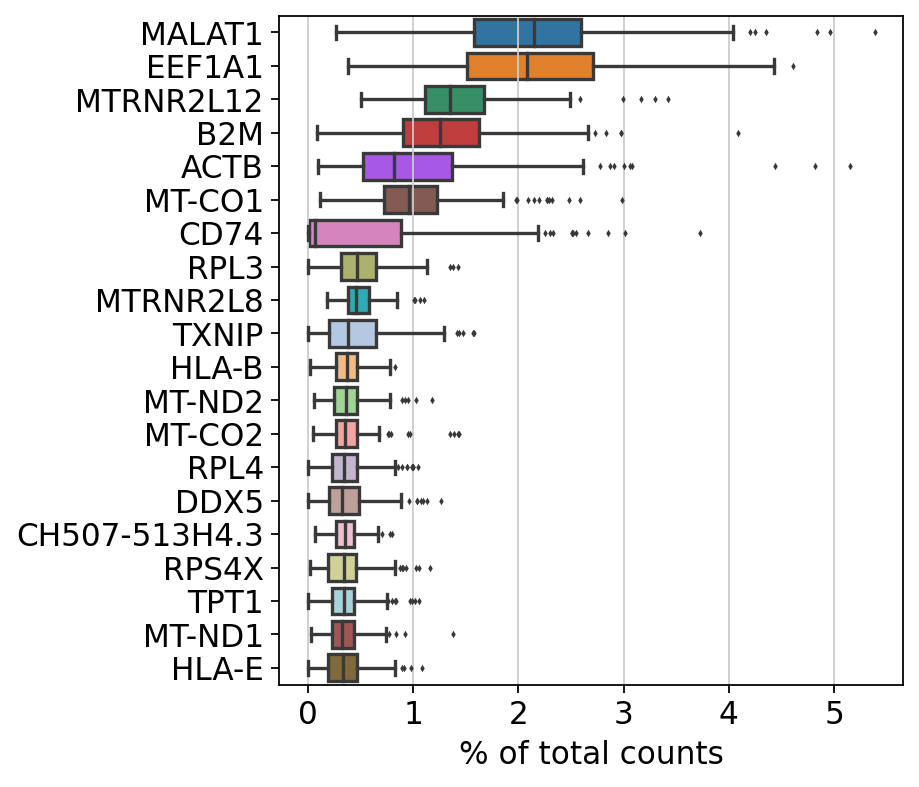

In [59]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [60]:
# filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=1)


filtered out 10432 genes that are detected in less than 1 cells


... storing 'CellType' as categorical
... storing 'Experiment' as categorical
... storing 'Method' as categorical


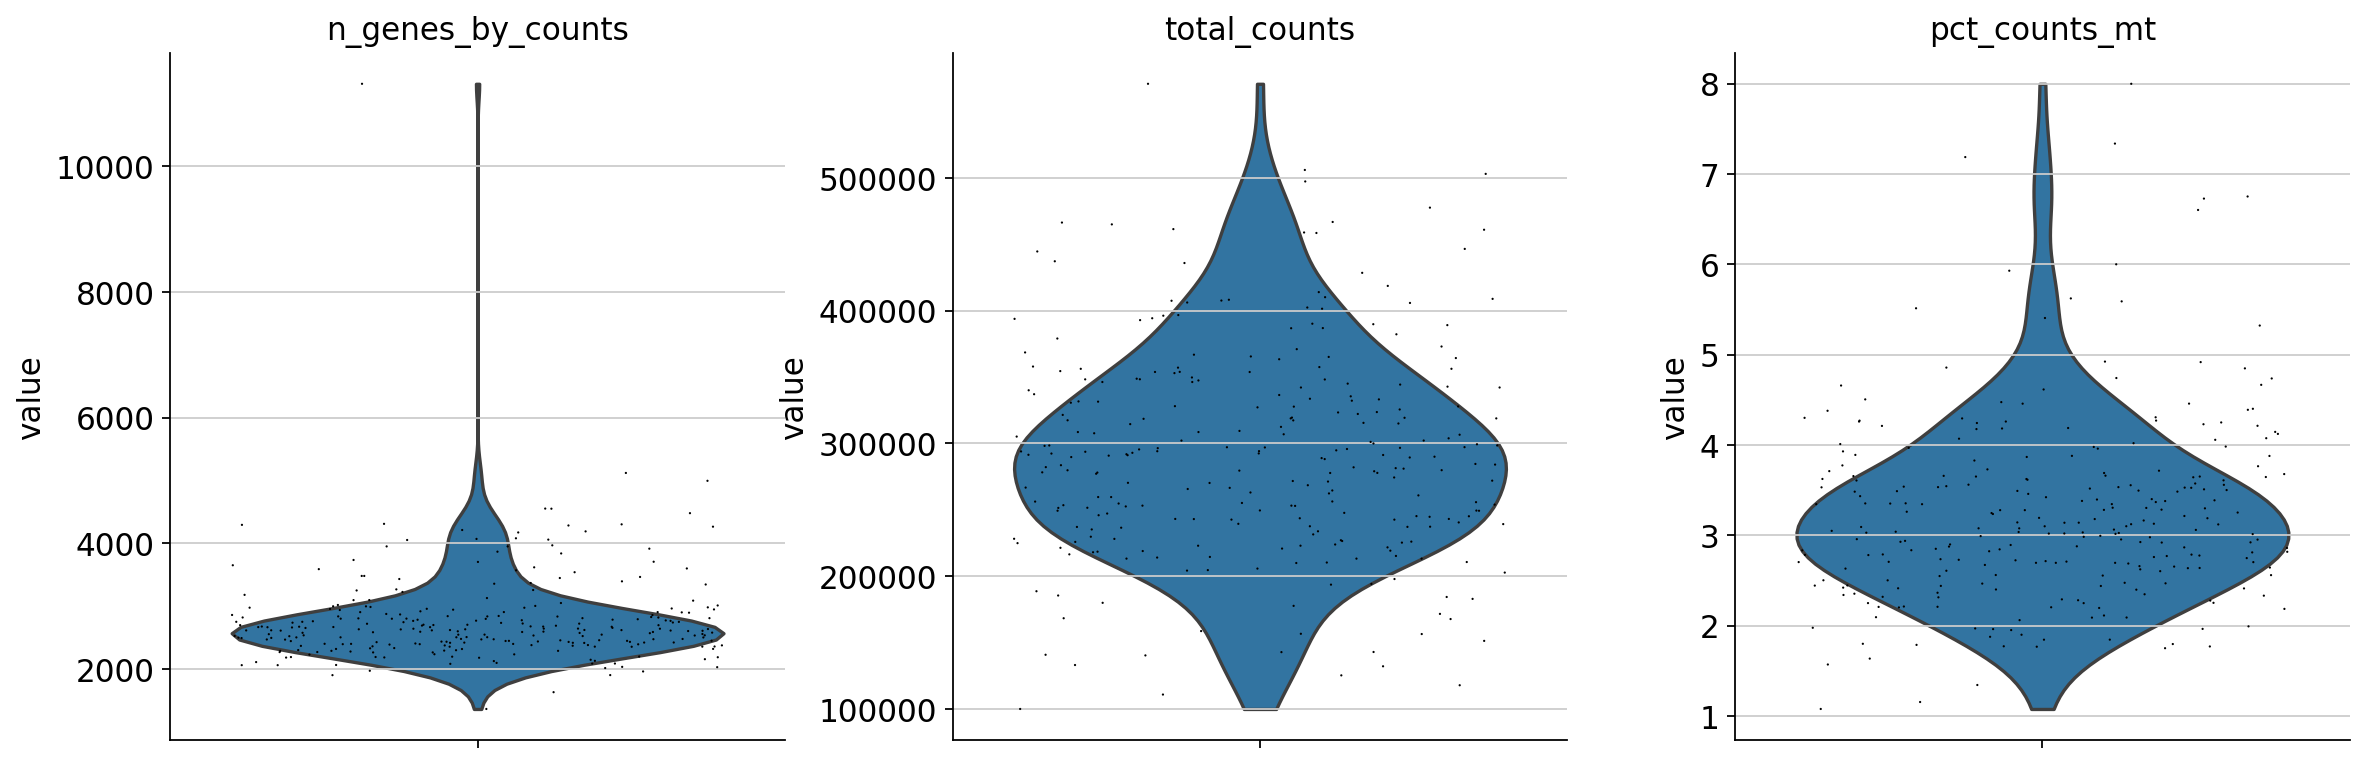

In [61]:
# remove genes with high mitochondrial content
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

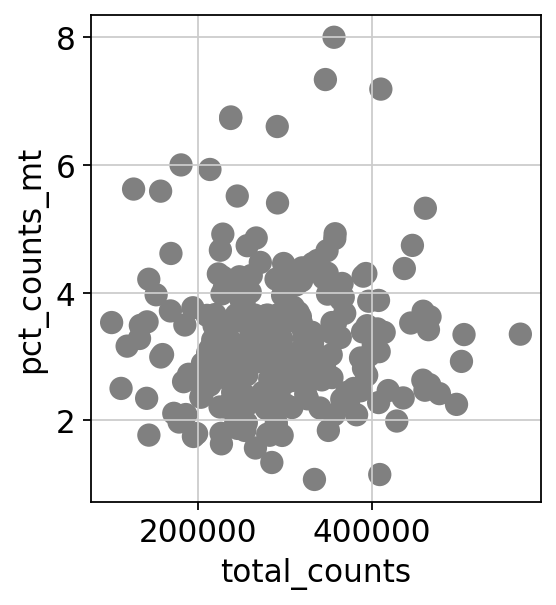

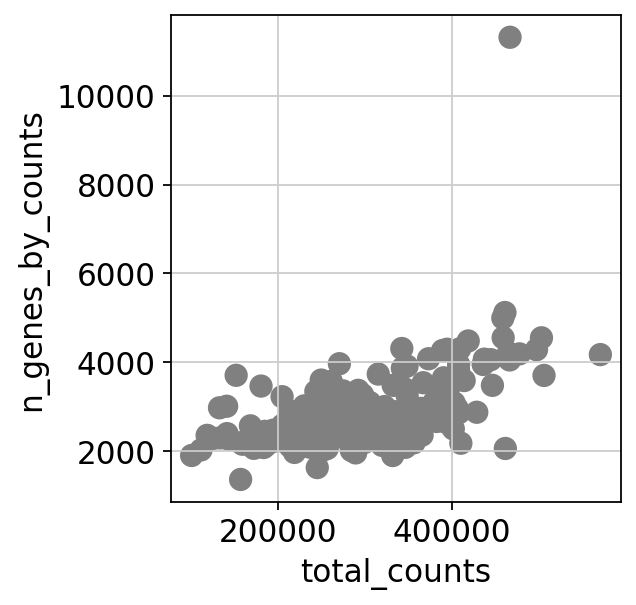

In [62]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [63]:
# slice the data based on the plots from above
# remove cells with more than 2500 genes
# remove cells with more than 5% MTgenes
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = adata[adata.obs.pct_counts_mt < 7, :]

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


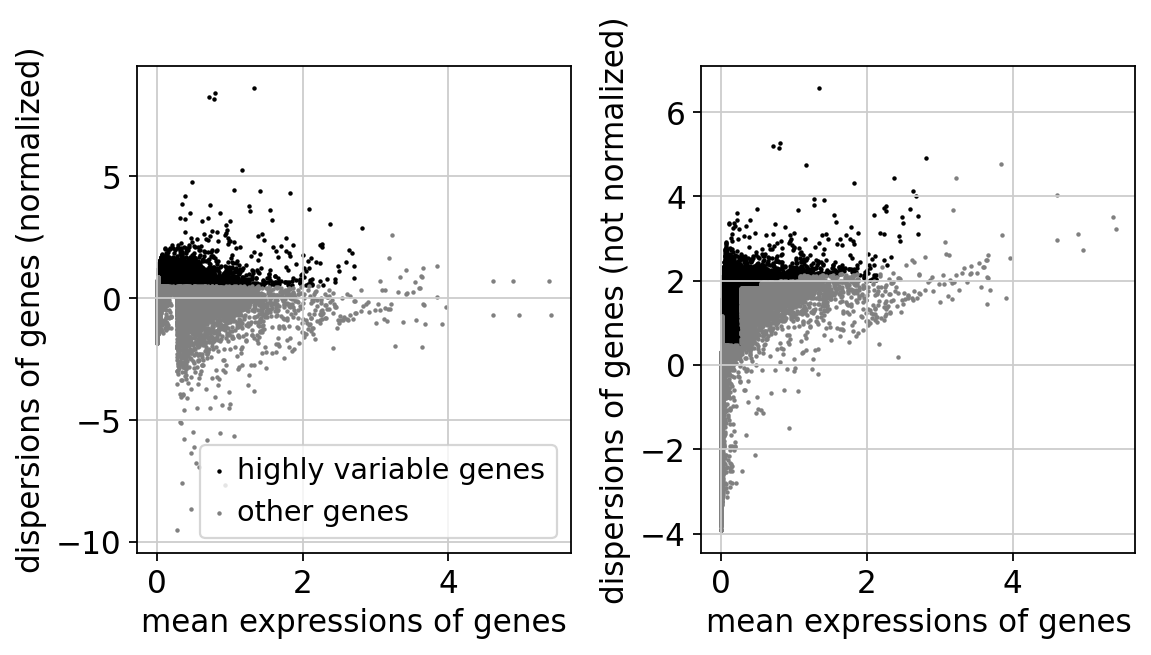

In [64]:
# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# log data
sc.pp.log1p(adata)

# get high variance genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(adata)

# now store the raw version of the data for our use later
adata.raw = adata
adata.write(results_file)


In [65]:
# now process the counts further for doing DE 
# analysis and the cell clustering
adata = adata[:, adata.var.highly_variable]

# regress out the signal
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# scale the genes
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:22)


## PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


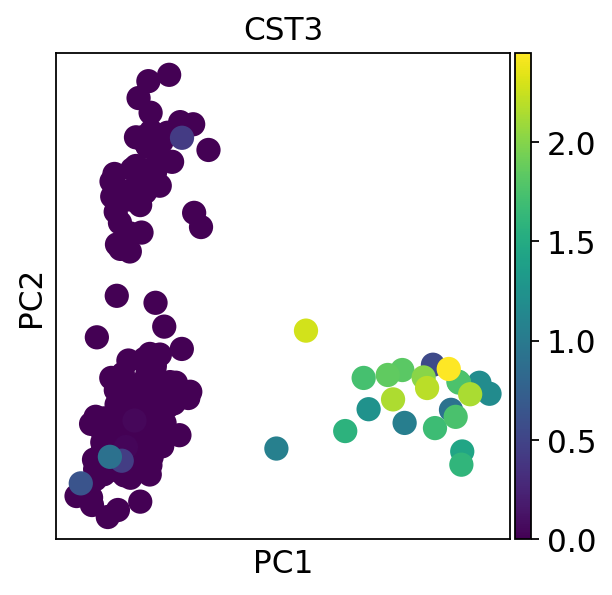

In [66]:
sc.tl.pca(adata, n_comps=50)
sc.pl.pca(adata, color='CST3')


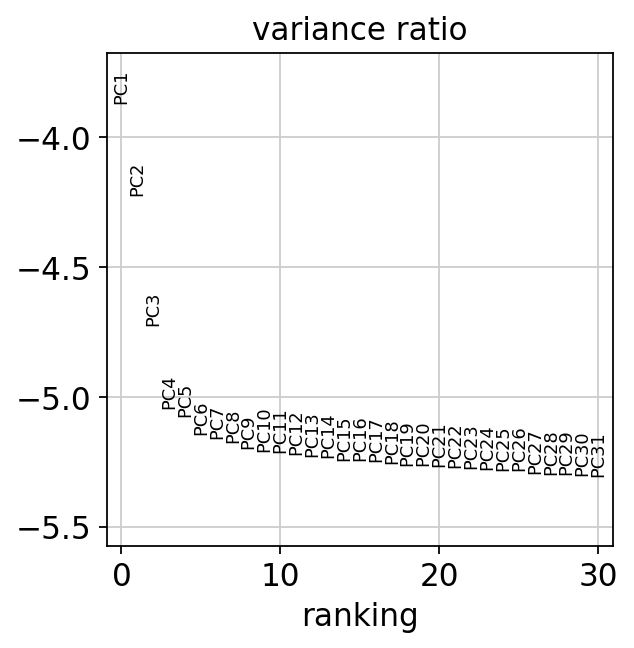

In [67]:
sc.pl.pca_variance_ratio(adata, log=True)


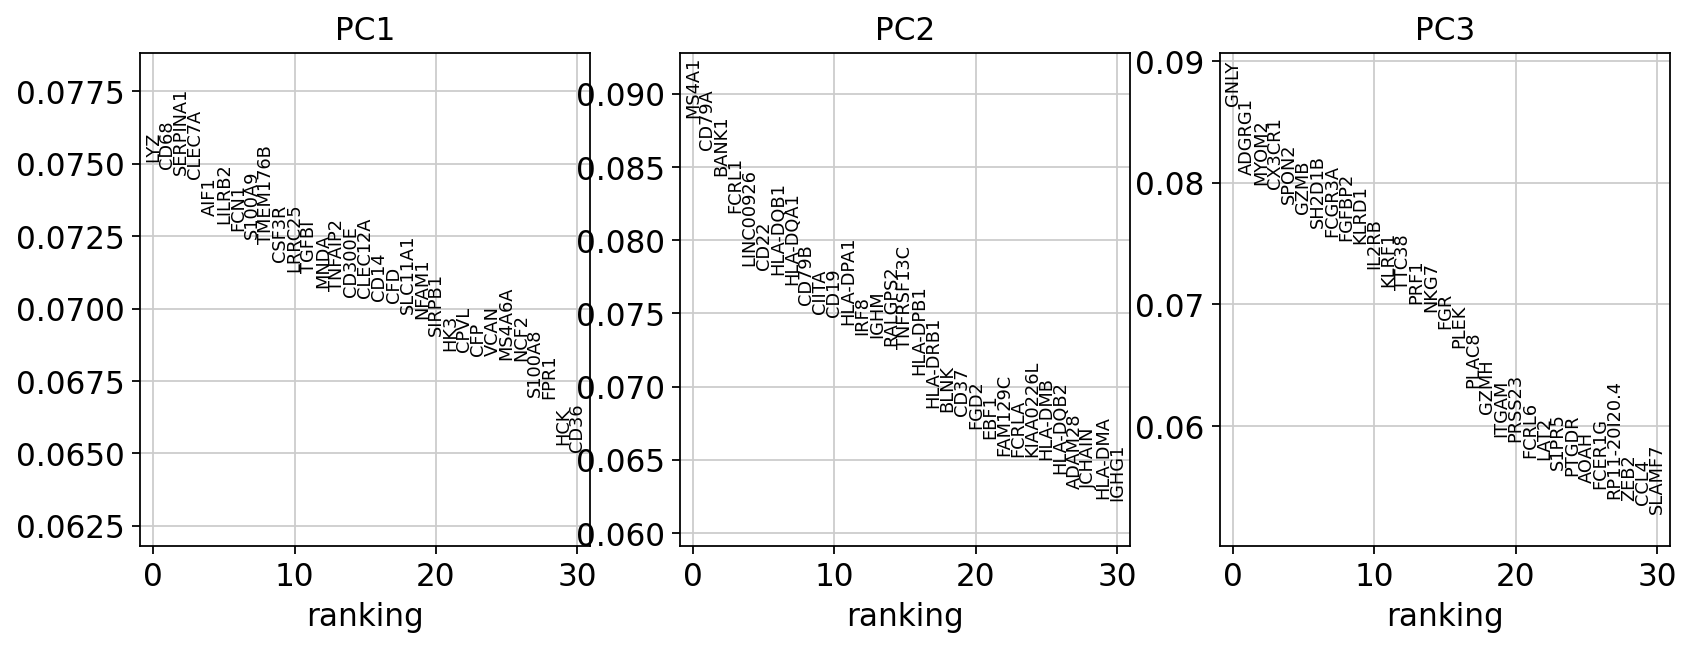

In [68]:
sc.pl.pca_loadings(adata, include_lowest=False)


In [69]:
# save results
adata.write(results_file)


## Compute and embed neighborhood graph

In [70]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


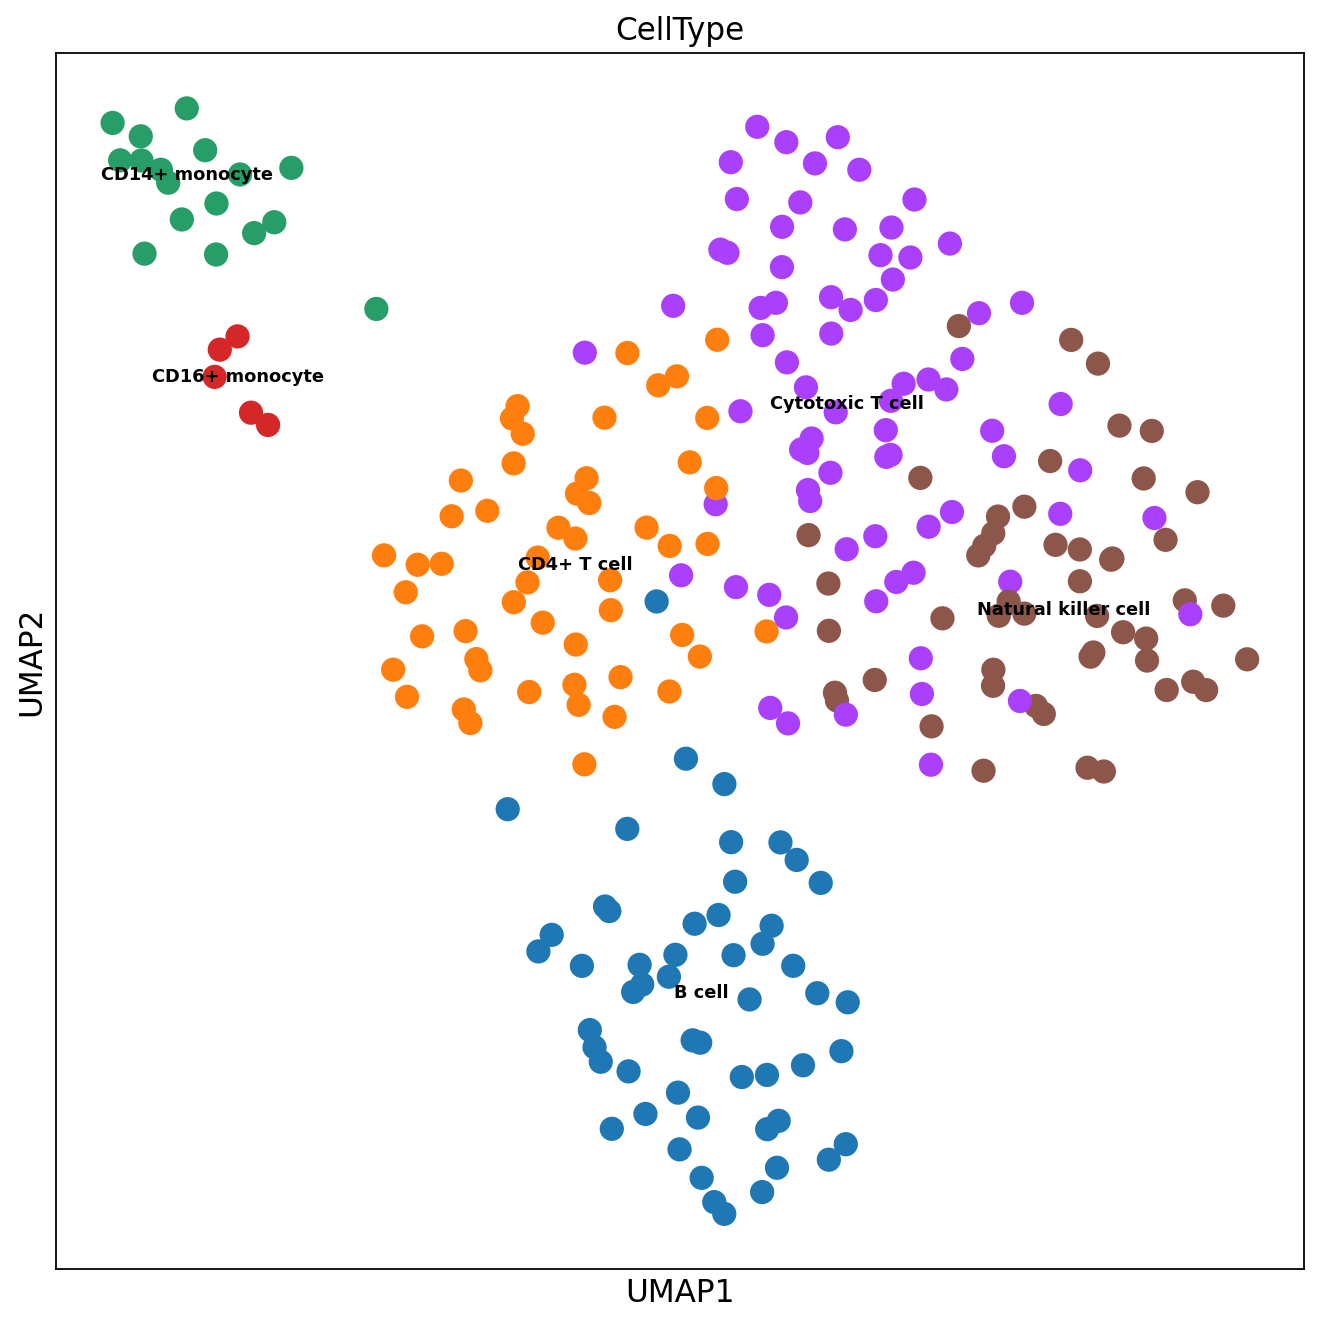

In [71]:
# plot some markers of the RAW data
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, legend_loc='on data', color='CellType', legend_fontsize=8)

## Cluster the neighborhood graph

running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


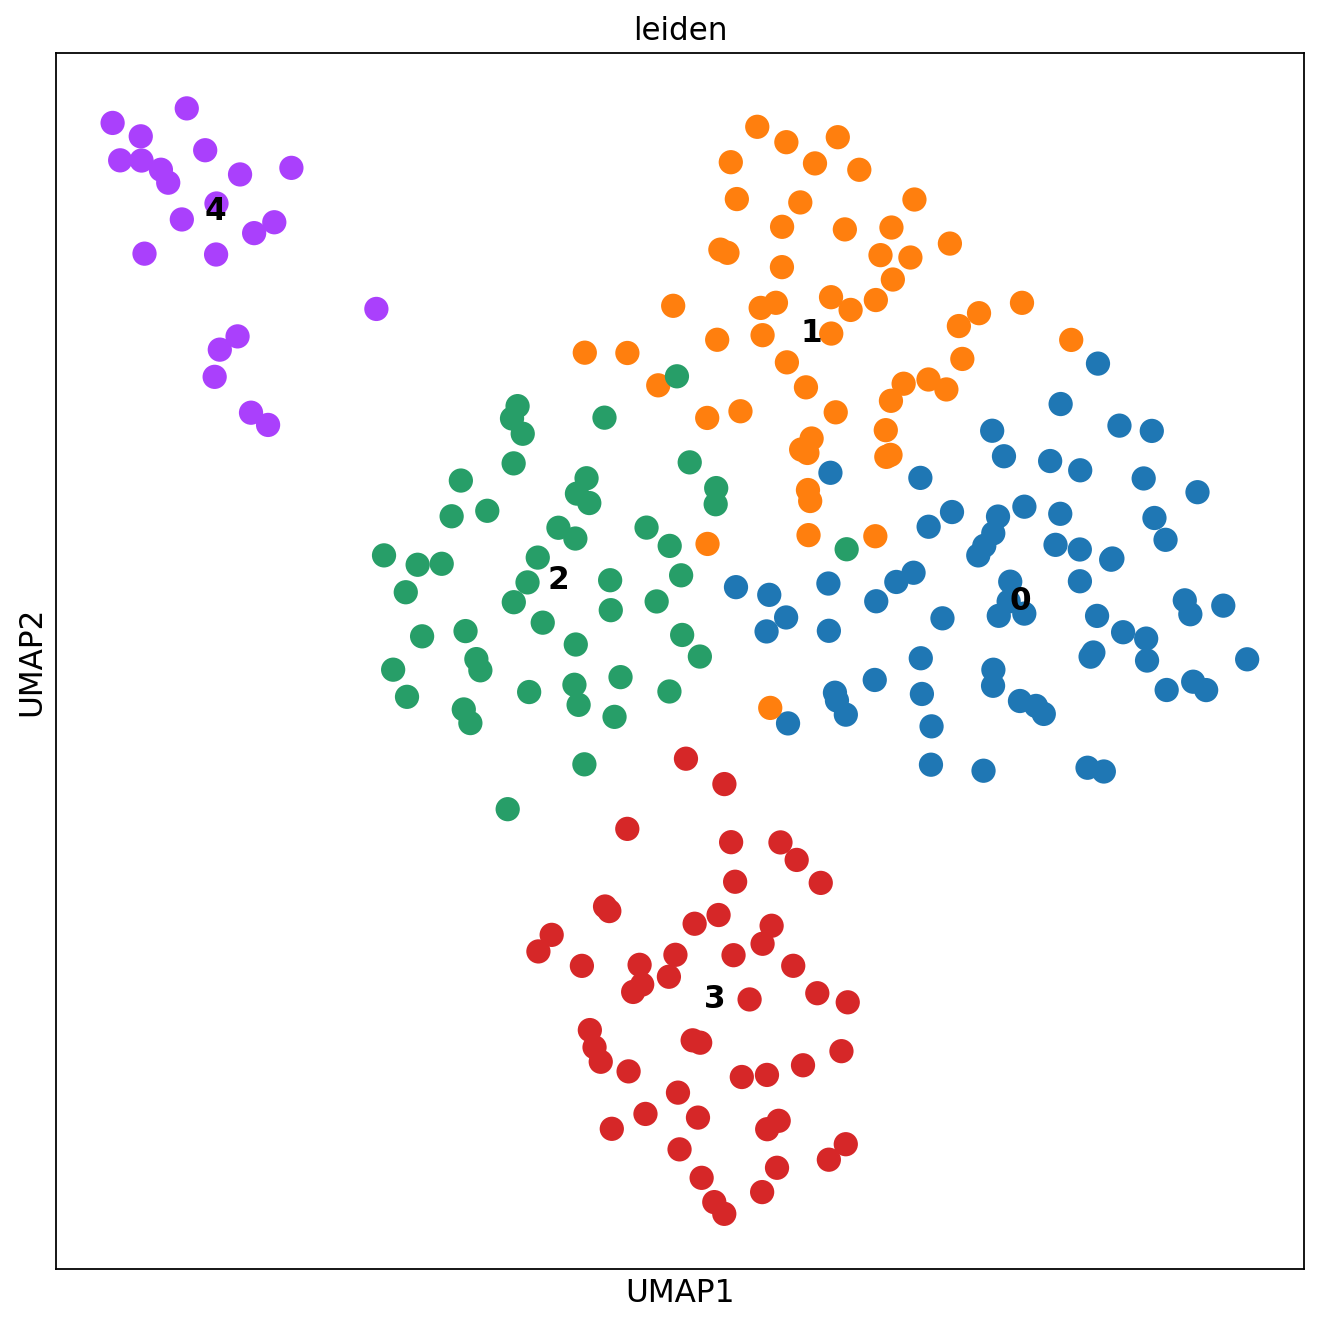

In [72]:
# lets use Leiden clustering
sc.tl.leiden(adata, resolution=1)
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color='leiden', legend_loc='on data')

# save
adata.write(results_file)


# merge cell type labels

In [73]:
# make cell type predictions
cell_dict = {'CD4+ T cell': ['2'], 'B cell': ['3'], 'Cytotoxic T cell': ['1'], 'CD14+ monocyte': ['4'],
    'Natural killer cell': ['0']}


# Initialize empty column in cell metadata
adata.obs['clust_label'] = np.nan

# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'clust_label'] = i

In [74]:
# write out how many of each cell type are found in both and each
celltype_consistent = adata.obs['clust_label'][adata.obs['clust_label'] == adata.obs['CellType']]
frequency = collections.Counter(celltype_consistent)
print("Freq. of Cell type  consistent between publication and clustering")
print(dict(frequency))

frequency = collections.Counter(adata.obs['CellType'])
print("Freq. of Cell type in publication")
print(dict(frequency))

frequency = collections.Counter(adata.obs['clust_label'])
print("Freq. of Cell type in clustering")
print(dict(frequency))




Freq. of Cell type  consistent between publication and clustering
{'CD14+ monocyte': 17, 'Natural killer cell': 47, 'Cytotoxic T cell': 49, 'CD4+ T cell': 46, 'B cell': 51}
Freq. of Cell type in publication
{'CD14+ monocyte': 17, 'Natural killer cell': 50, 'Cytotoxic T cell': 75, 'CD4+ T cell': 52, 'B cell': 53, 'CD16+ monocyte': 5}
Freq. of Cell type in clustering
{'CD14+ monocyte': 22, 'Natural killer cell': 71, 'Cytotoxic T cell': 57, 'CD4+ T cell': 51, 'B cell': 51}


In [75]:
celltype_notconsistent = np.where(adata.obs['clust_label'] != adata.obs['CellType'])
adata.obs['merged'] = adata.obs['clust_label']
adata.obs['merged'][celltype_notconsistent[0]] = np.nan

... storing 'clust_label' as categorical
... storing 'merged' as categorical


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_CellType']`
categories: B cell, CD4+ T cell, CD14+ monocyte, etc.
var_group_labels: CD14 Mono, CD16 Mono, Dendritic, etc.


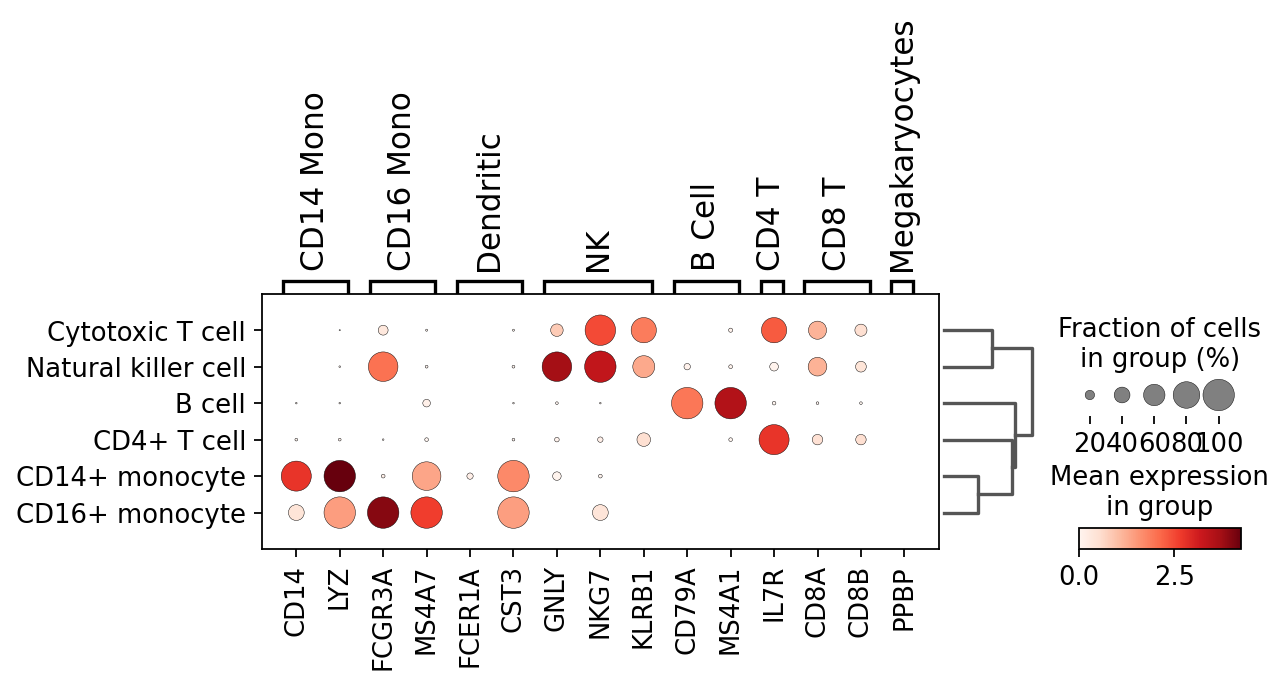

In [76]:
# now as a dotplot show it for all samples
sc.pl.dotplot(adata, marker_genes_dict, groupby='CellType', dendrogram=True)


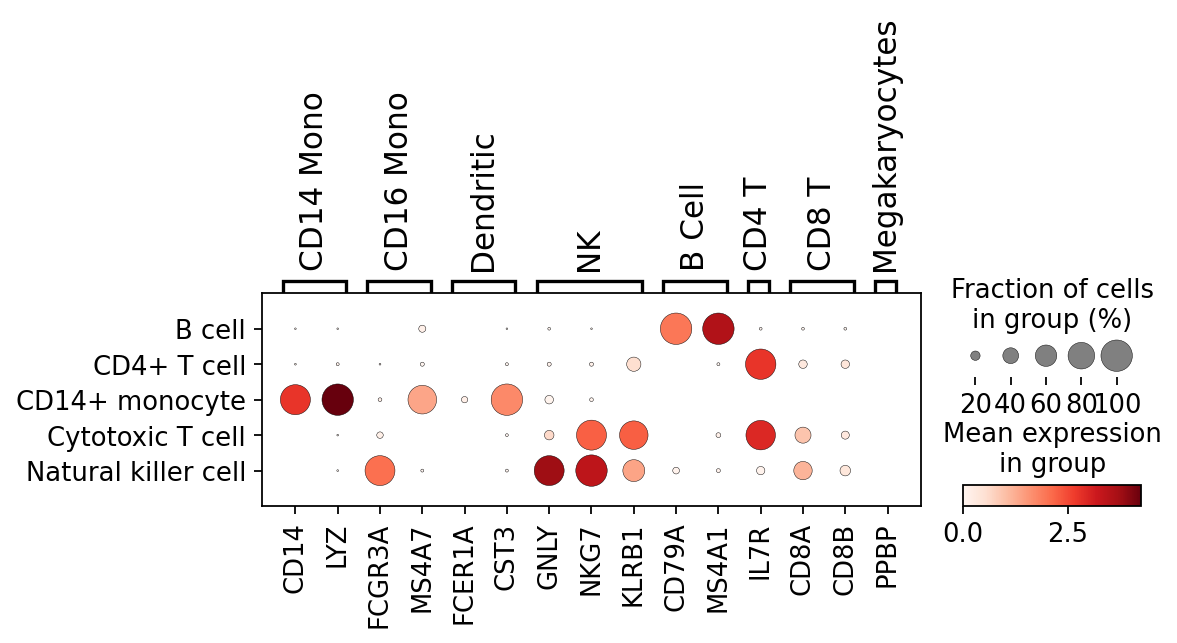

In [77]:
# now as a dotplot show it for all samples
sc.pl.dotplot(adata, marker_genes_dict, groupby='merged', dendrogram=False)


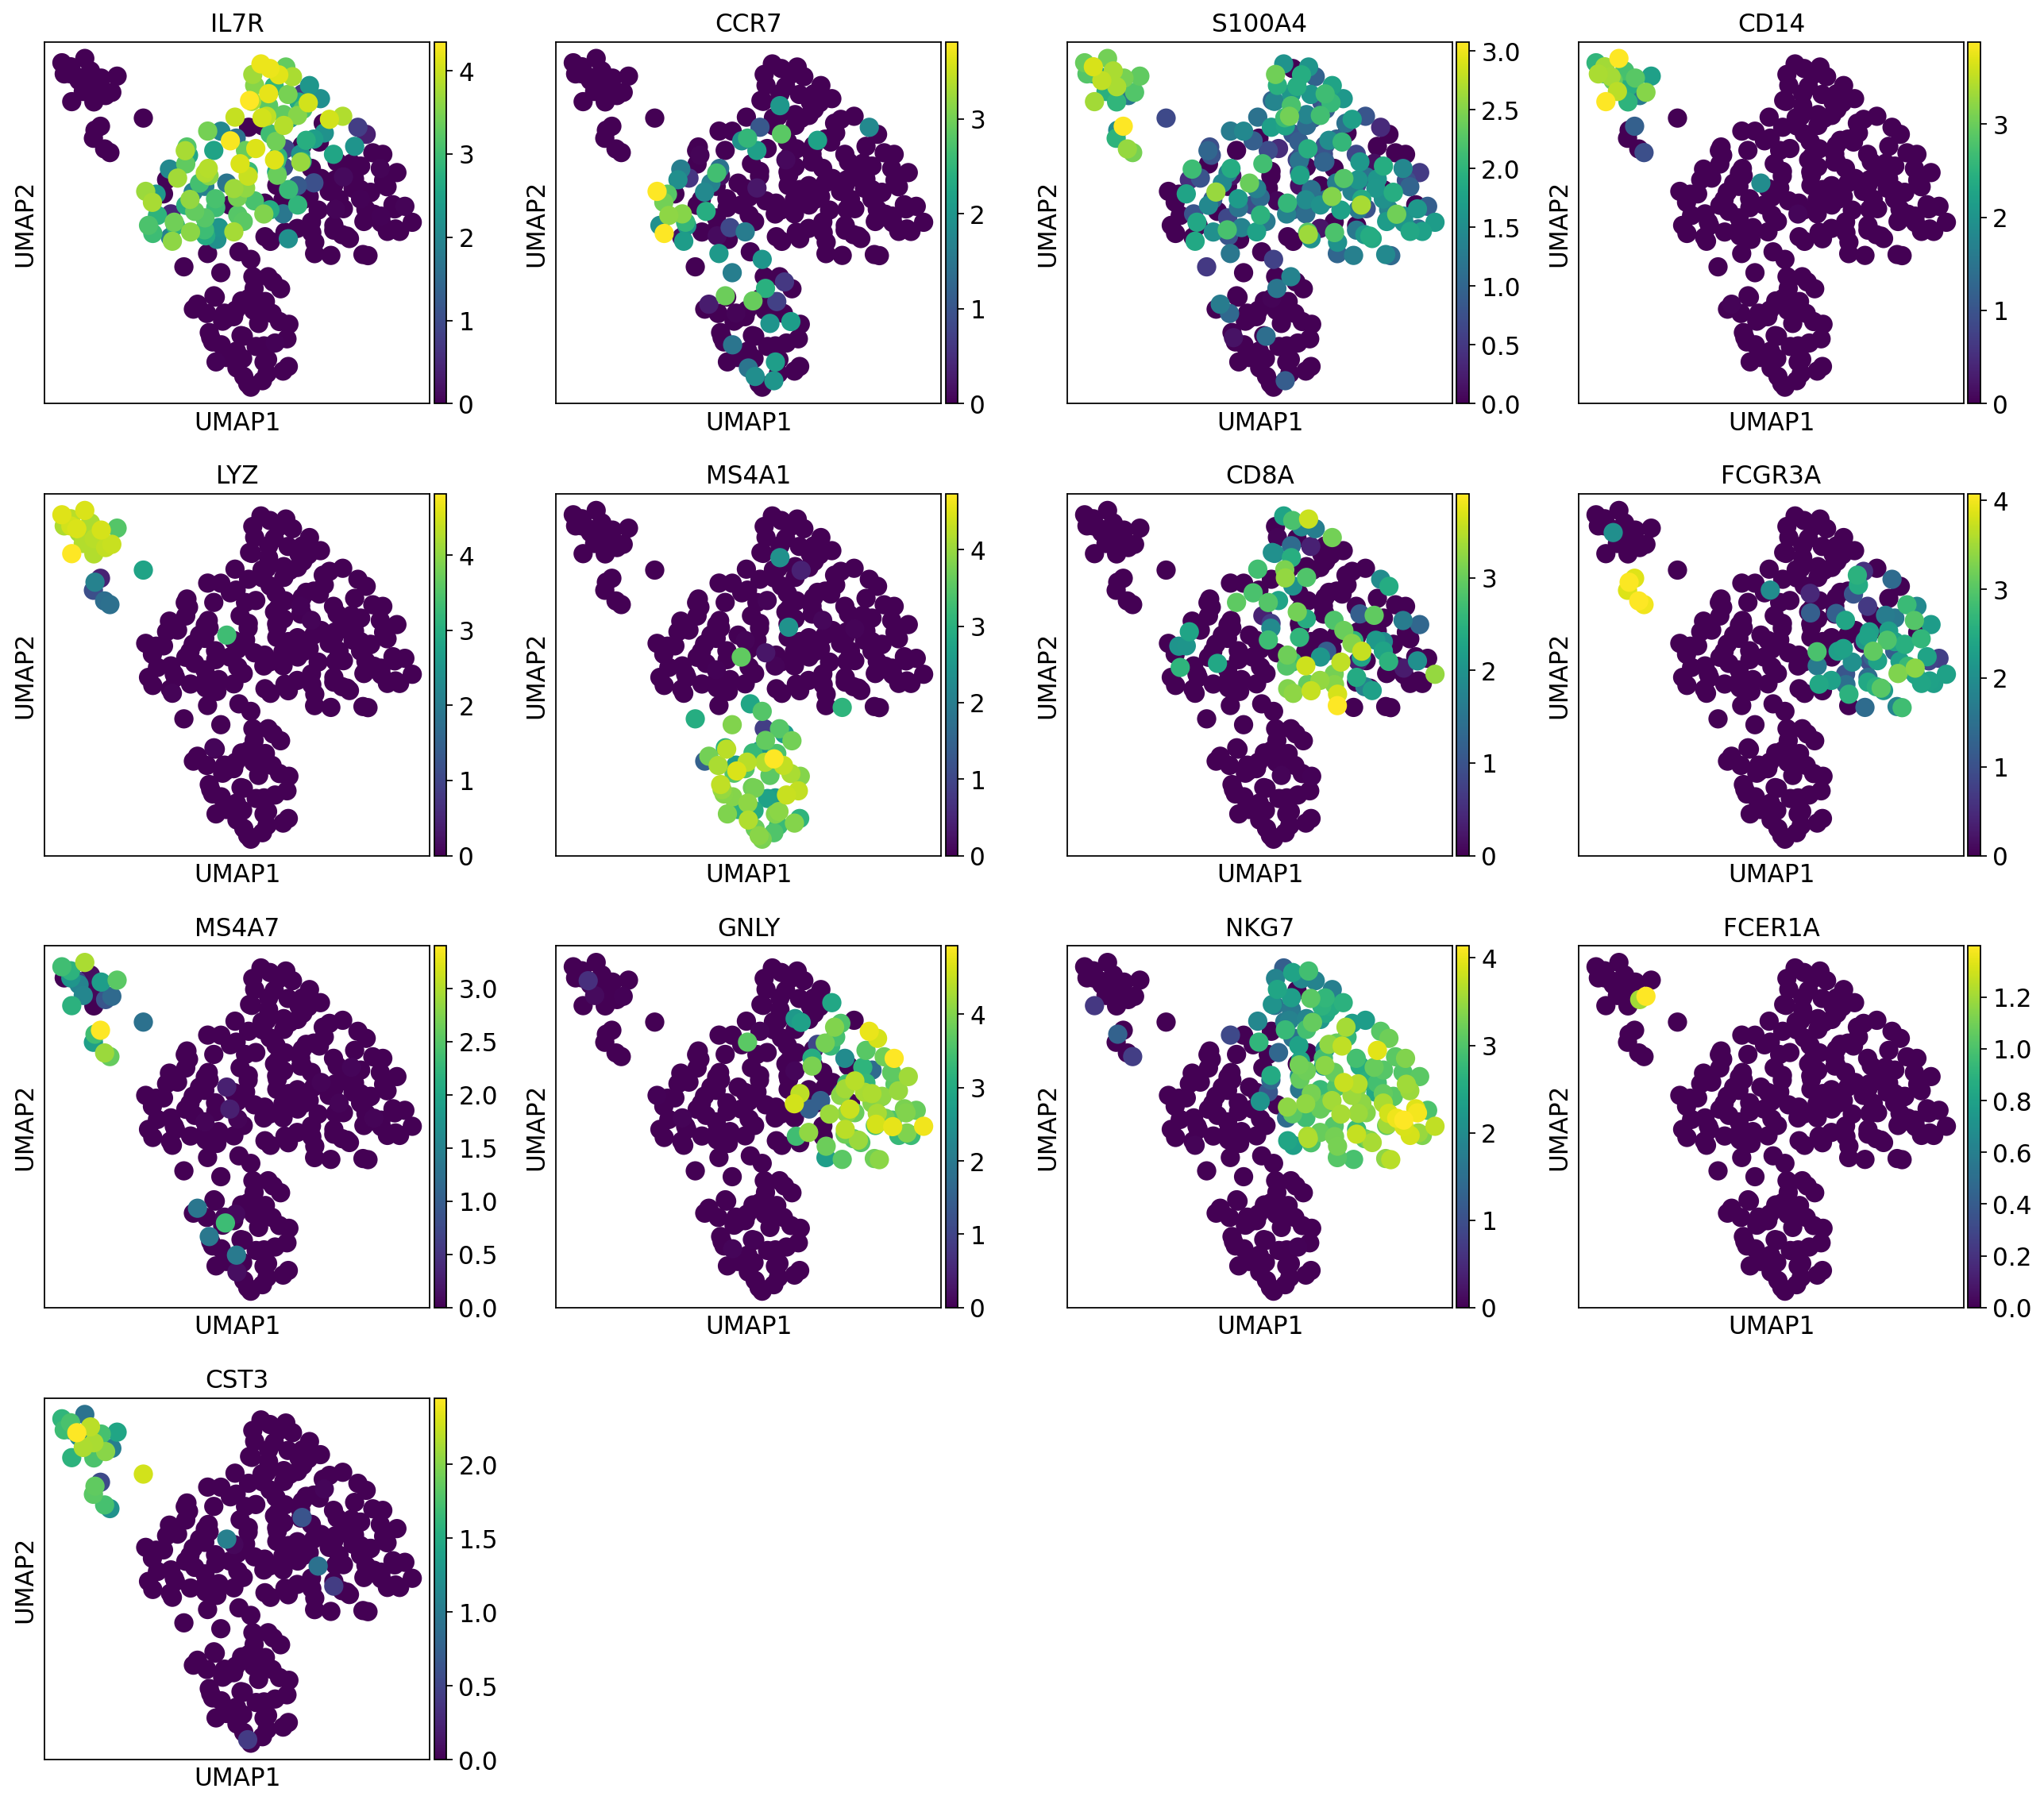

In [78]:
gene_list = ['IL7R', 'CCR7', 'S100A4', 'CD14', 'LYZ', 'MS4A1', 'CD8A',
    'FCGR3A', 'MS4A7', 'GNLY', 'NKG7', 'FCER1A', 'CST3']

sc.pl.umap(adata, color=[i for i in gene_list], color_map='viridis', legend_fontsize=8)

## Find marker genes

ranking genes
    finished (0:00:00)


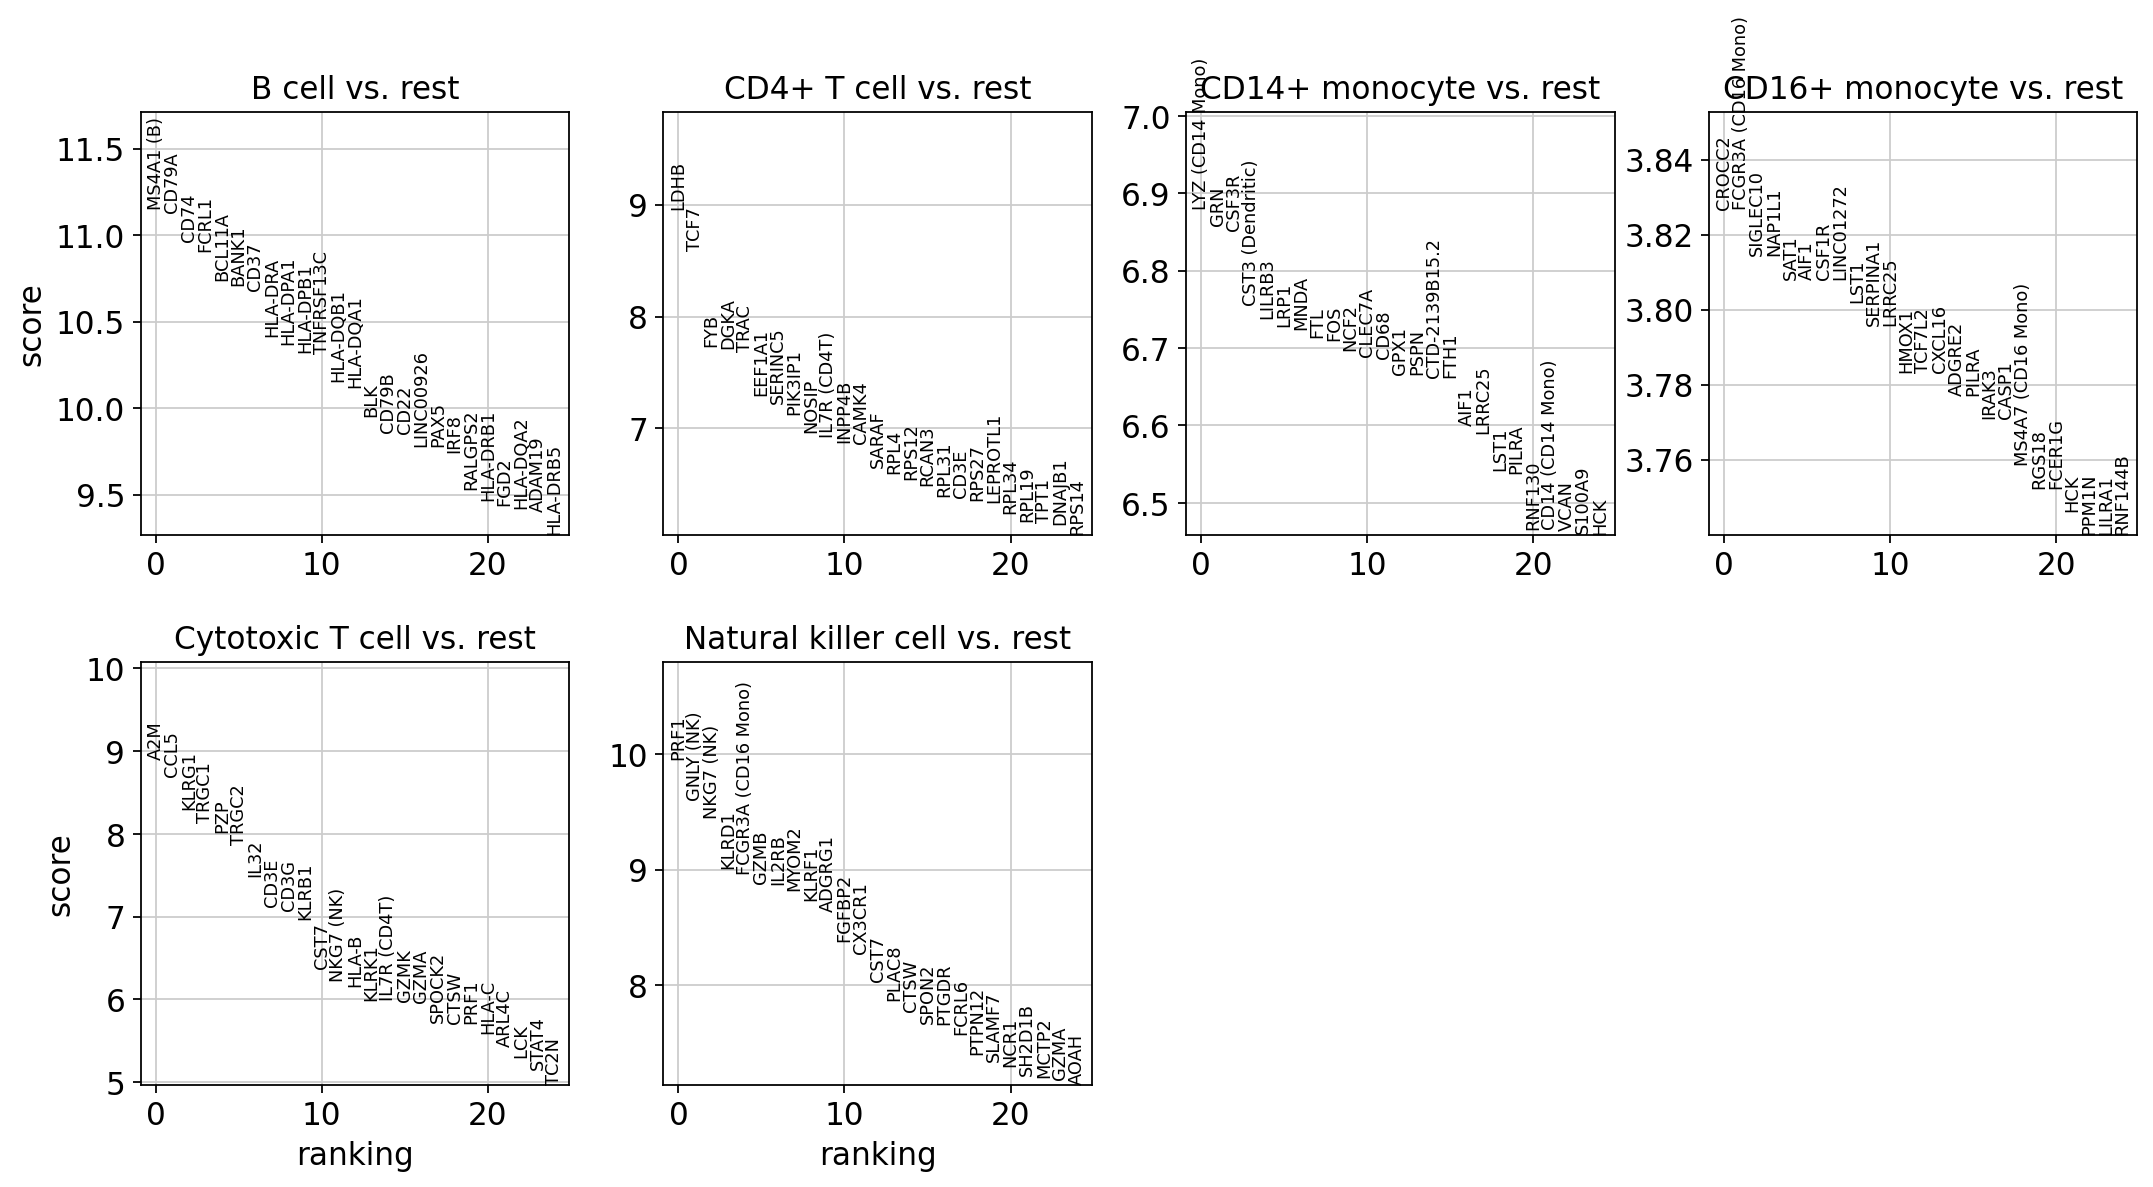

In [85]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata, 'CellType', method='wilcoxon') # we will use wilcoxon over t-test
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols="gene_annot")
adata.write(results_file)

ranking genes
    finished (0:00:00)


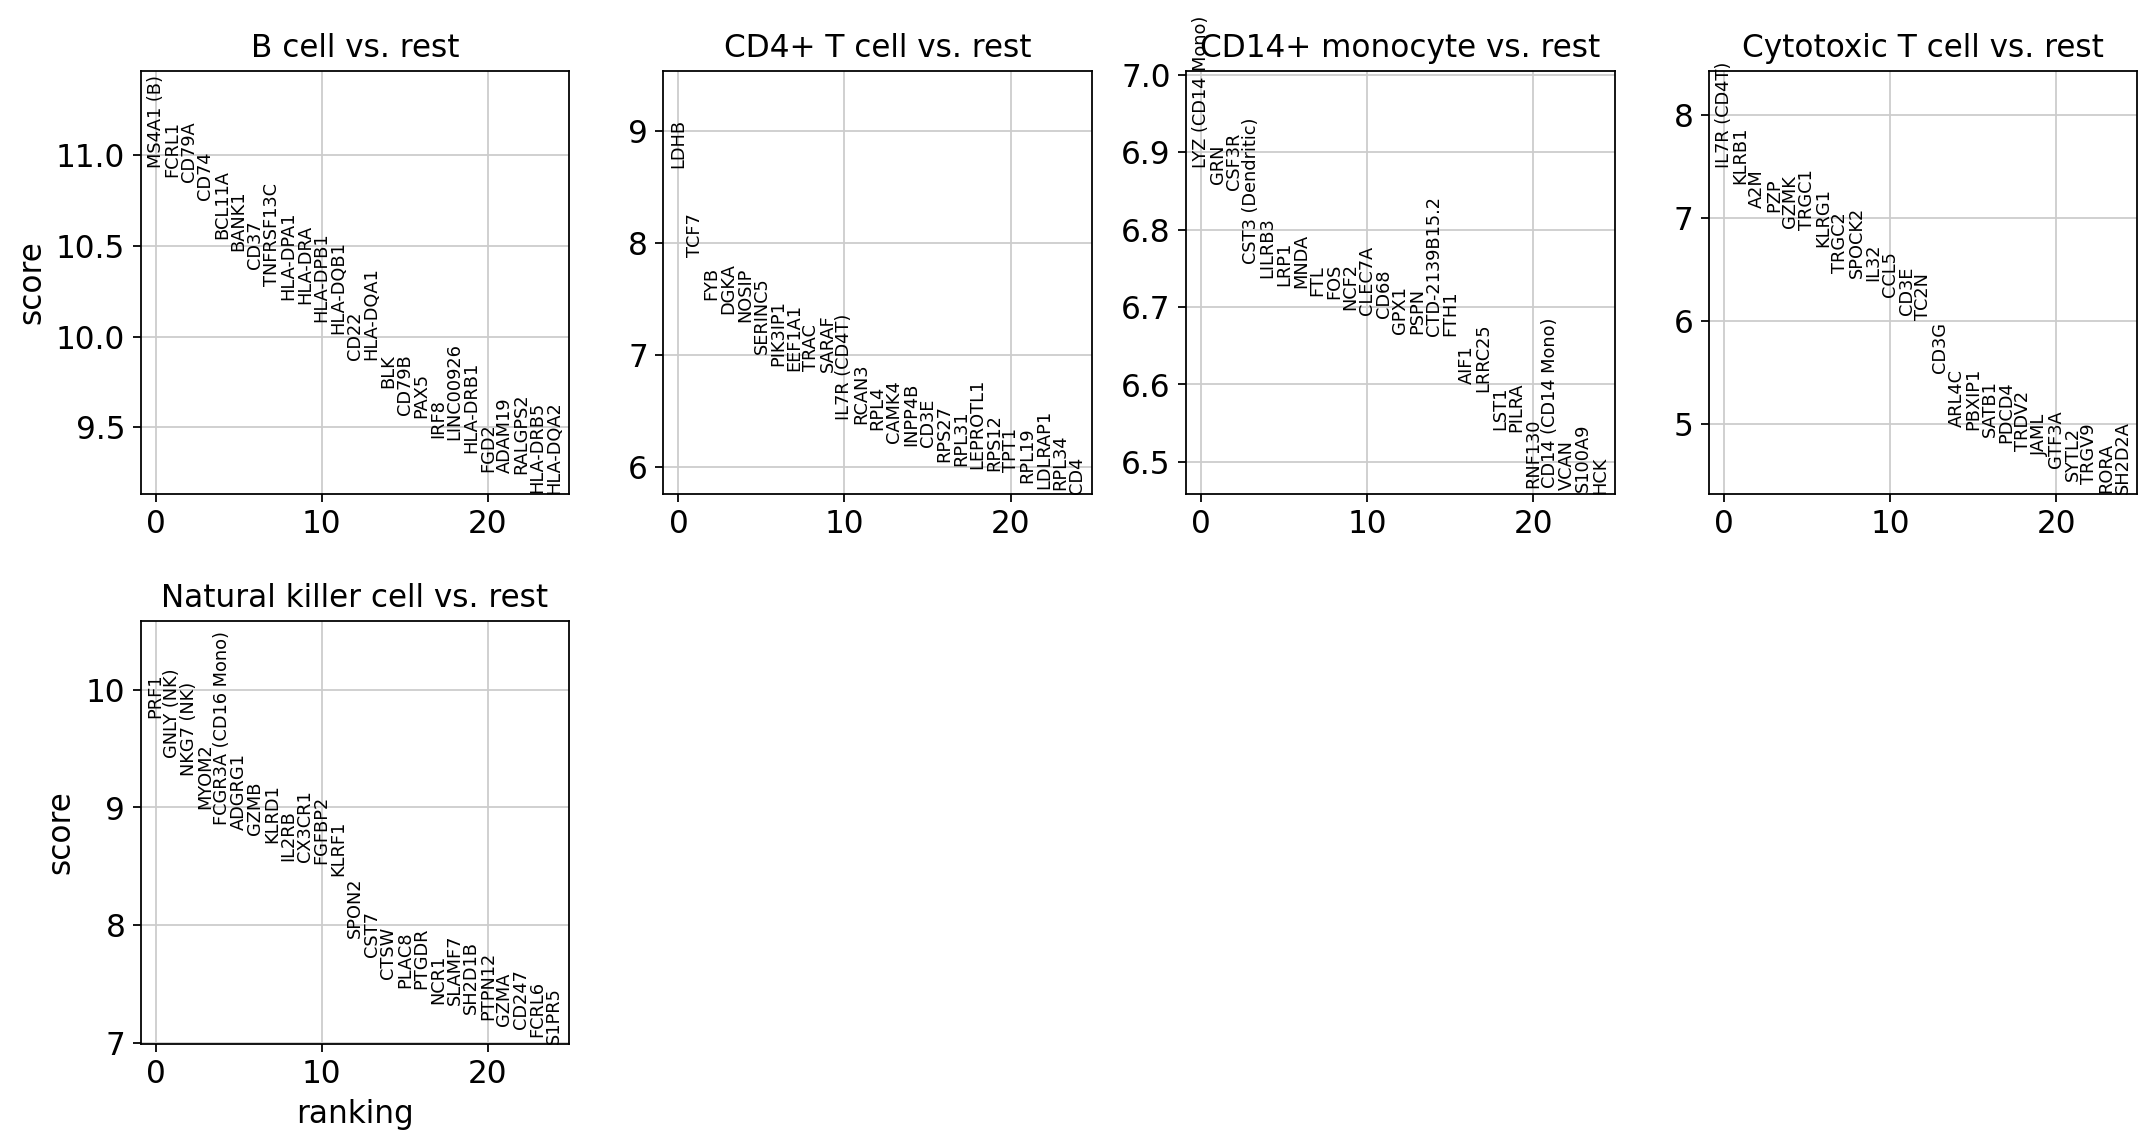

In [79]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata, 'merged', method='wilcoxon') # we will use wilcoxon over t-test
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols="gene_annot")
adata.write(results_file)


In [80]:
# show top 10 genes per cluster
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)


,B cell,CD4+ T cell,CD14+ monocyte,Cytotoxic T cell,Natural killer cell
0,MS4A1,LDHB,LYZ,IL7R,PRF1
1,FCRL1,TCF7,GRN,KLRB1,GNLY
2,CD79A,FYB,CSF3R,A2M,NKG7
3,CD74,DGKA,CST3,PZP,MYOM2
4,BCL11A,NOSIP,LILRB3,GZMK,FCGR3A


In [81]:
# show p-values
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})

,B cell_n,B cell_l,CD4+ T cell_n,CD4+ T cell_l,CD14+ monocyte_n,CD14+ monocyte_l,Cytotoxic T cell_n,Cytotoxic T cell_l,Natural killer cell_n,Natural killer cell_l
0,MS4A1,8.723255,LDHB,2.962759,LYZ,10.525927,IL7R,3.726251,PRF1,4.661331
1,FCRL1,8.019276,TCF7,2.801805,GRN,6.218434,KLRB1,3.312184,GNLY,6.521207
2,CD79A,7.302276,FYB,2.496408,CSF3R,8.568444,A2M,2.555221,NKG7,4.026098
3,CD74,5.318065,DGKA,2.915922,CST3,6.598851,PZP,2.571498,MYOM2,5.643033
4,BCL11A,6.089802,NOSIP,2.958853,LILRB3,6.240393,GZMK,4.171528,FCGR3A,4.519326
...,...,...,...,...,...,...,...,...,...,...
23257,ITGB2,-3.159652,CST7,-3.617645,CLEC2D,-3.326081,SYK,-29.594906,RPS12,-1.303267
23258,GIMAP4,-11.361447,PRF1,-5.084729,IKZF3,-8.605273,FGD2,-8.246406,RPS8,-1.235707
23259,GIMAP7,-31.794315,CD74,-3.309454,S1PR1,-30.422655,HLA-DRA,-5.219633,RPL13A,-1.070730
23260,ZAP70,-31.459156,NKG7,-5.274484,TRBC2,-30.885456,LAT2,-9.834066,RPL4,-1.390523


In [82]:
result.keys()

dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])

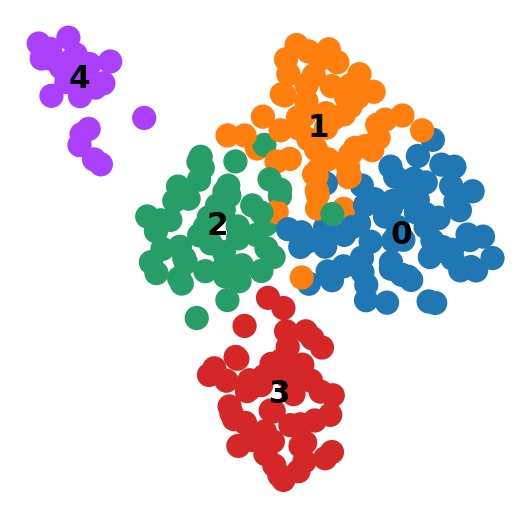

In [83]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf', )


In [84]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading
